In [4]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import keras.backend as K
from keras.models import *
from keras.layers import *

from keras import optimizers
from keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob

#Preprocessing using scikit learn 
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Load EEG data of all subjects 

In [6]:
def load_eeg_data():
    '''
    Function to load EEG data of all subjects 
    '''
    eeg_data = []
    for name in glob.glob('*.mat'):
        # data import from matlab
        subject = sio.loadmat(name)   #Load the matlab file for a single subject 
        data_subject = subject['data']


        # shuffle trials
        (channel, trial, time_points)= data_subject.shape

        trials = np.arange(trial)
        np.random.shuffle(trials)

        #Z score
        data_subject=stats.zscore(format_1, axis=2)
        
        eeg_data.append(data_subject)
    return np.array(eeg_data)    
        

In [7]:
!ls

1-D_convolutional_ python3final7_keras.ipynb
1.mat
1filtered.mat
2.mat
3.mat
4.mat
5.mat
EEG_Data_to_Process
Linear_Regression.ipynb
Linear_Regression.py
__pycache__
keras_logs.textClipping
linear_reg python3final7.ipynb
linear_reg python3final7_keras.ipynb
logs
vanilla_RNN python3final7_keras.ipynb


In [27]:


# data import from matlab
subject_1 = sio.loadmat('1.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [28]:
eeg_data = load_eeg_data()

In [29]:
format_1

array([[[ 9.84851807e-01, -1.89219310e+00,  2.93743360e-01, ...,
         -1.17354152e+00, -2.89814327e-03, -1.38385235e+00],
        [ 9.83913601e-01,  1.07896660e+00, -3.63498200e-03, ...,
          2.77015028e-01,  6.90176262e-01, -5.50286551e-02],
        [ 3.19486170e-01, -2.61757777e-01,  1.84686834e-01, ...,
         -1.43468476e-01, -1.29438022e+00, -1.62525978e+00],
        ...,
        [ 6.21291956e-01,  1.92180227e-01, -1.56909104e-01, ...,
          2.74827285e-02,  1.56456282e+00,  5.72567107e-01],
        [ 1.32148919e+00, -1.34483276e+00, -2.63819219e-01, ...,
          1.39975751e+00, -6.94720316e-01,  1.01333421e+00],
        [ 1.54018978e-01,  4.20703300e-01,  6.16924601e-01, ...,
         -3.10882384e-01, -9.76340154e-01, -8.71056457e-02]],

       [[ 1.35994045e+00,  1.54522697e+00,  1.51161800e+00, ...,
         -1.30702543e+00, -1.27604142e+00, -1.24289528e+00],
        [-1.41088126e+00, -3.82645658e-01, -1.46985345e+00, ...,
         -2.08182874e+00, -1.08054957e

In [30]:
print(type(format_1))



<class 'numpy.ndarray'>


In [31]:
def preprocess_data(data):
    #Reshape 3d array to 2d so it get's prrocessed by scikit learn
    channel, trial, time_points = data.shape[0], data.shape[1], data.shape[2]
    data = data.reshape(channel, -1)
    
    #Min max scaler for normalizing the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    normalized = scaler.transform(data)
    
    #reshape the data to 3D array again
    normalized = normalized.reshape(channel, trial, time_points)
    return normalized, scaler




In [32]:
def inv_data(data, scaler):
    #Reshape 3d array to 2d so it get's prrocessed by scikit learn
    channel, trial, time_points = data.shape[0], data.shape[1], data.shape[2]
    data = data.reshape(channel, -1)
    
    #Retrieve the original data
    inversed = scaler.inverse_transform(data)

    #reshape the data to 3D array again
    original_data = inversed.reshape(channel, trial, time_points)
    return original_data

In [33]:
format_1, scaler = preprocess_data(format_1)


In [34]:
format_1

array([[[0.74991711, 0.1817932 , 0.67792644, ..., 0.25080992,
         0.44326947, 0.11041374],
        [0.67341073, 0.62787308, 0.50086014, ..., 0.42986033,
         0.59112723, 0.2813218 ],
        [0.57784845, 0.50519801, 0.57301234, ..., 0.49668282,
         0.19684499, 0.15031813],
        ...,
        [0.62035175, 0.60234185, 0.56015898, ..., 0.58703211,
         0.9917696 , 0.62312685],
        [0.67837184, 0.24718958, 0.43556416, ..., 0.62929068,
         0.43942414, 0.671151  ],
        [0.57044751, 0.5920651 , 0.61599733, ..., 0.46258872,
         0.41617246, 0.49910705]],

       [[0.81937358, 0.82797619, 0.89016212, ..., 0.21997911,
         0.16256946, 0.1401925 ],
        [0.25877336, 0.36420034, 0.22990933, ..., 0.03658467,
         0.24800088, 0.06969588],
        [0.71502908, 0.70105618, 0.74053315, ..., 0.08079605,
         0.03097676, 0.11049001],
        ...,
        [0.76827372, 0.80657817, 0.82354207, ..., 0.28320011,
         0.25630526, 0.09634951],
        [0.5

In [35]:
format_1 = inv_data(format_1, scaler)
format_1

array([[[ 9.84851807e-01, -1.89219310e+00,  2.93743360e-01, ...,
         -1.17354152e+00, -2.89814327e-03, -1.38385235e+00],
        [ 9.83913601e-01,  1.07896660e+00, -3.63498200e-03, ...,
          2.77015028e-01,  6.90176262e-01, -5.50286551e-02],
        [ 3.19486170e-01, -2.61757777e-01,  1.84686834e-01, ...,
         -1.43468476e-01, -1.29438022e+00, -1.62525978e+00],
        ...,
        [ 6.21291956e-01,  1.92180227e-01, -1.56909104e-01, ...,
          2.74827285e-02,  1.56456282e+00,  5.72567107e-01],
        [ 1.32148919e+00, -1.34483276e+00, -2.63819219e-01, ...,
          1.39975751e+00, -6.94720316e-01,  1.01333421e+00],
        [ 1.54018978e-01,  4.20703300e-01,  6.16924601e-01, ...,
         -3.10882384e-01, -9.76340154e-01, -8.71056457e-02]],

       [[ 1.35994045e+00,  1.54522697e+00,  1.51161800e+00, ...,
         -1.30702543e+00, -1.27604142e+00, -1.24289528e+00],
        [-1.41088126e+00, -3.82645658e-01, -1.46985345e+00, ...,
         -2.08182874e+00, -1.08054957e

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


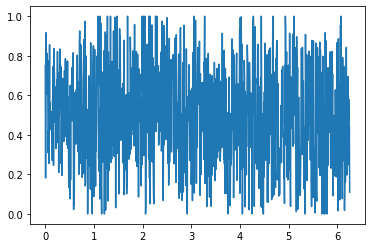

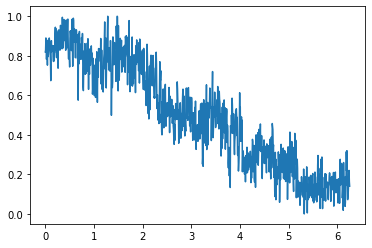

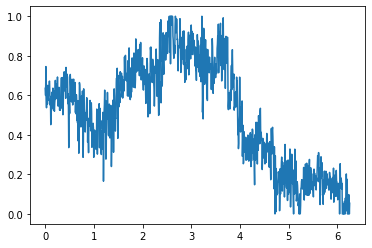

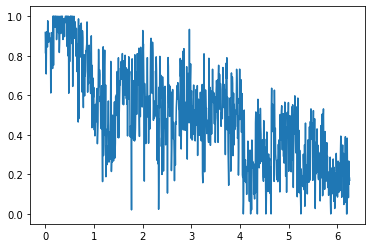

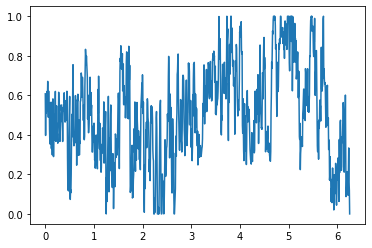

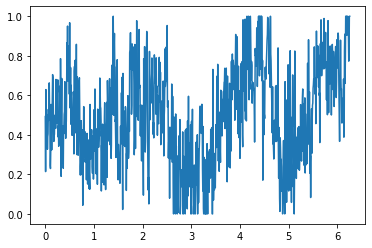

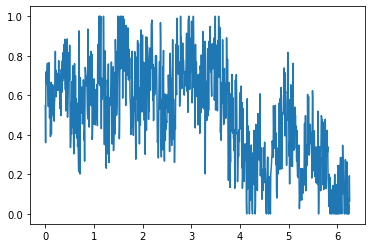

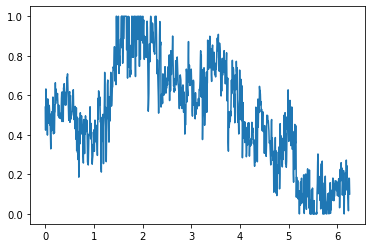

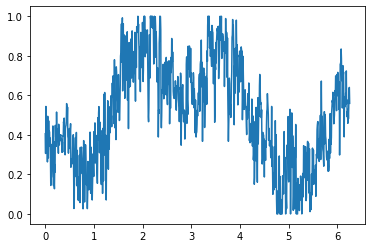

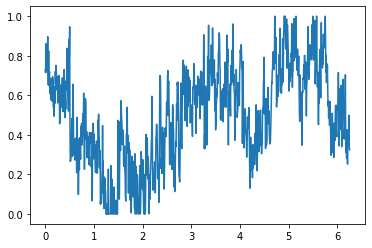

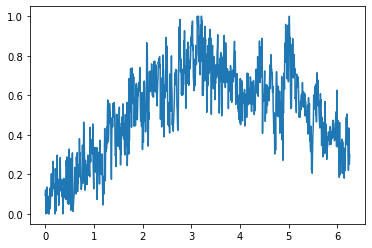

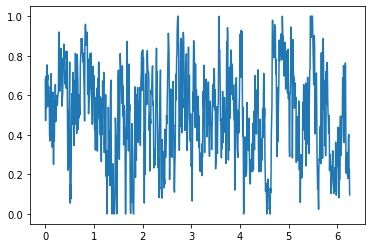

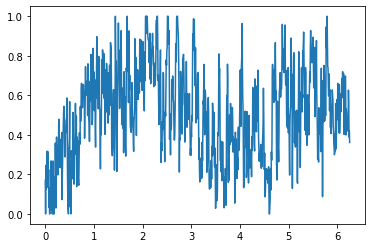

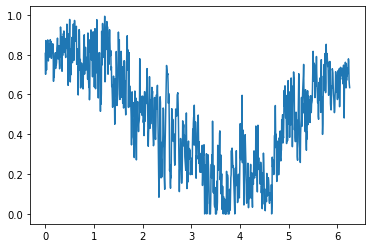

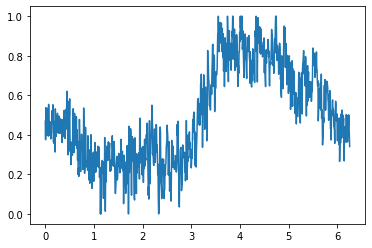

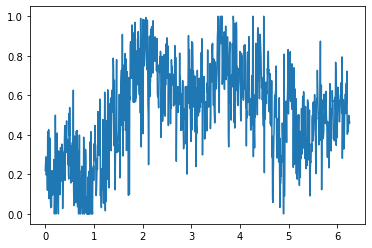

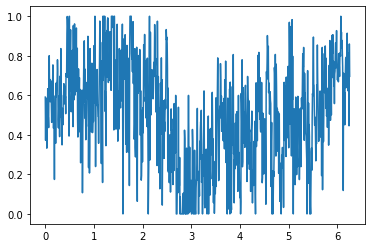

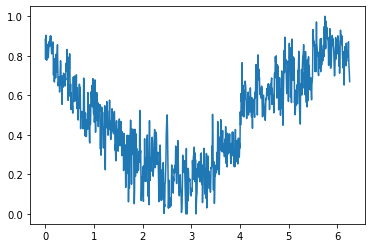

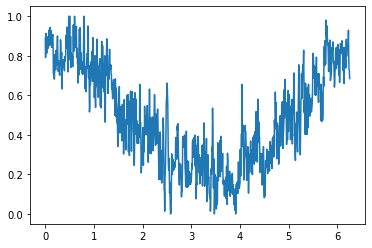

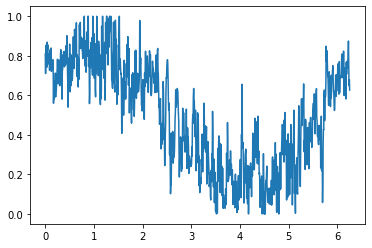

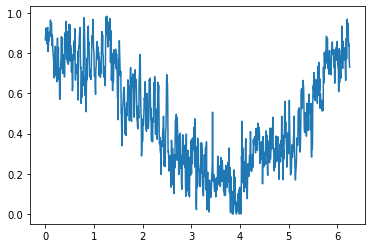

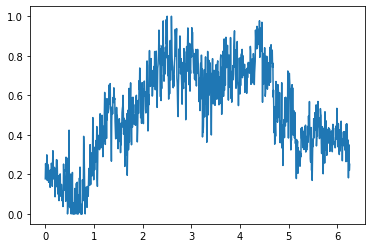

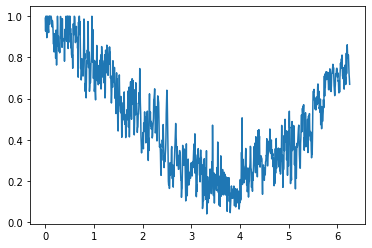

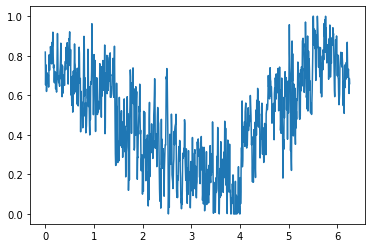

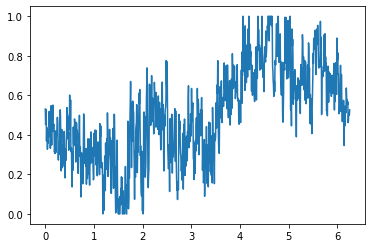

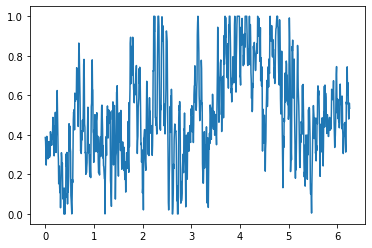

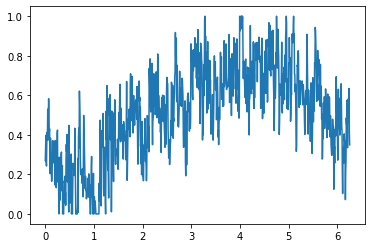

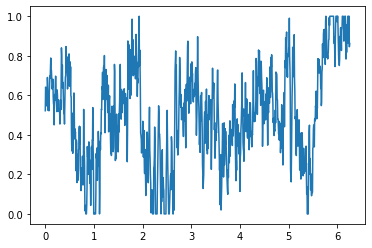

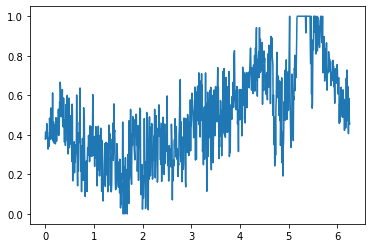

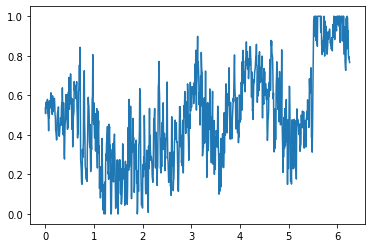

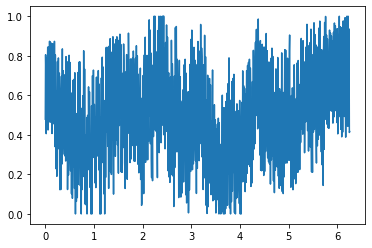

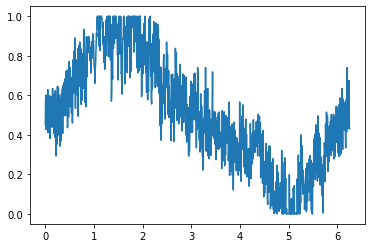

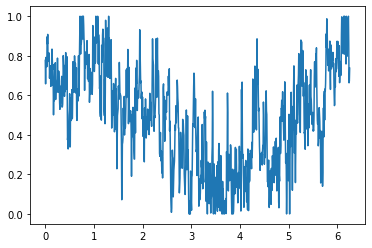

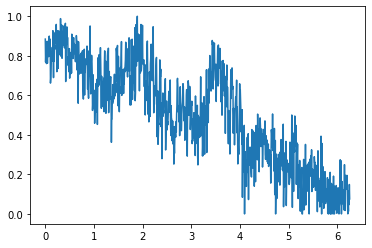

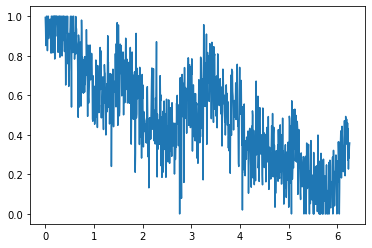

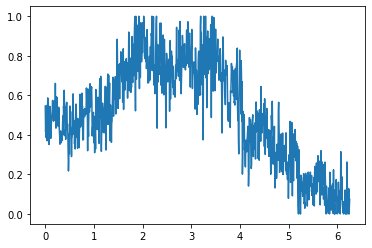

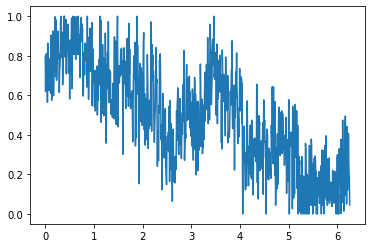

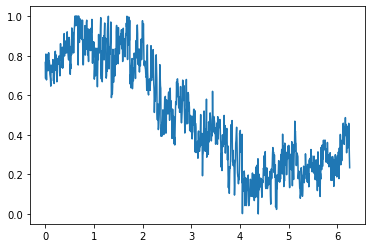

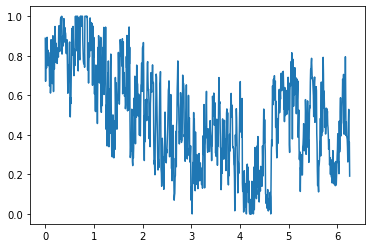

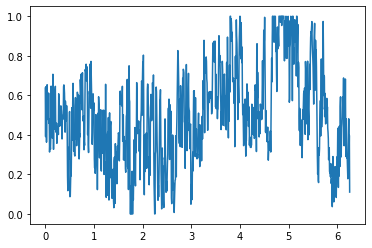

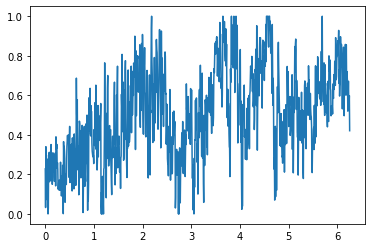

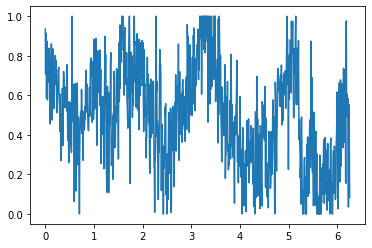

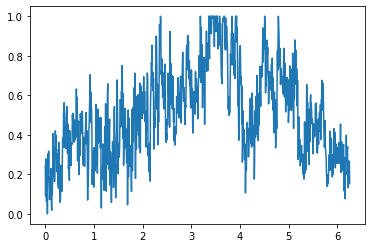

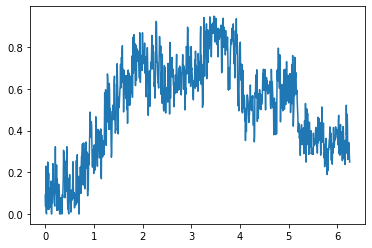

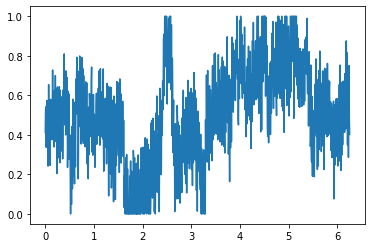

In [ ]:
#Plot EEG
#plot of a single channel of EEG
%matplotlib inline
Time = np.linspace(0, 6.25, 1000)
for i in range (channel):
    plt.plot(Time, format_1[i][0])
    plt.figure()
plt.plot(Time, format_1[52][1])



In [ ]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

stim = input ('''Enter the number of stimuli:''')
stim = int(stim)

relation = input('''Please define what should be predicted (1 for EEG or 2 for stimulus):''')

if relation == '1':
    source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
    source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi

hiLaSi_tmp = input('''please specify the number of layers and neurons per desired layers: ''')
hidden_layers = list(map(int, hiLaSi_tmp.split()))
print (hidden_layers)
print (type(hidden_layers))

learning_rate = input('''enter the lambda / learning rate: ''')
learning_rate = float(learning_rate)      # conversion as a decimal number

In [ ]:
def split_data(data):
    (subject, channel, trial, time_points) = data.shape
    
    #Sepration of train train / valid / test sets into 80 %, 10 % and 10 % of the data respectively.
    
    train_num = int(np.around(len(trials) * 0.8))
    valid_num = int(np.around(len(trials) * 0.1))
    test_num = len(trials) - train_num - valid_num
    
    

In [ ]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [19]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, ((time_points-stim)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [20]:
def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
    x_tmp = [[]]*((time_points-stim)*batch_num)                       #creation of an empty list x_tmp of size (129630,)
    x_tmp = np.matrix(x_tmp)                                #conversion as a matrix 129630 * 0 (number of lines good)
    x_tmp = np.transpose(x_tmp)                             #transposition 1: form 0 * 129630, necessary at n.append
                                                            #avoid the transposition line in the for loop (2 transpo instead of 160
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
        k = 0
        while k < stim:                                     #160 loops - recovery of the 840 values ​​of each test (in the form test 1, test 2, ...), shifted by 1 at each iteration
            tmp = format_1[i, batch_trials, k:(time_points-stim+k)]    #see extract_Y
            tmp = np.reshape(tmp,((time_points-stim)*batch_num))
            tmp = np.matrix(tmp)
            
            x_tmp = np.append(x_tmp, tmp, axis=0)           #concatenation of the matrix tmp 1 * 129360 at the end of the matrix x_tmp (k + 1) * 129360
            k = k+1
    x_tmp = np.transpose(x_tmp)                             #transposition 2: form 129360 * (160 * nbr_électrode)
    return x_tmp
        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160)
x_valid.shape =  (15960, 160)
x_test.shape =  (15960, 160)


In [16]:
#tensorflow - Linear regression cf github

training_epochs = 100
display_step = 10

train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160)
(129360, 1)


In [21]:
train_X

matrix([[-1.79819558, -1.37764219, -0.60244001, ...,  0.37263362,
          1.57302948,  1.12761229],
        [-1.37764219, -0.60244001, -1.03832999, ...,  1.57302948,
          1.12761229, -0.56377588],
        [-0.60244001, -1.03832999, -1.69633424, ...,  1.12761229,
         -0.56377588, -1.27466853],
        ...,
        [ 1.54462768,  0.74689337,  0.61046249, ...,  0.42094491,
          1.82568295,  1.44340268],
        [ 0.74689337,  0.61046249,  0.69978381, ...,  1.82568295,
          1.44340268, -1.12609543],
        [ 0.61046249,  0.69978381,  1.0833052 , ...,  1.44340268,
         -1.12609543, -1.44285506]])

In [22]:



scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_X)
normalized = scaler.transform(train_X)

normalized



array([[0.04550391, 0.15167529, 0.34738002, ..., 0.59354357, 0.89659115,
        0.78414275],
       [0.15167529, 0.34738002, 0.23733682, ..., 0.89659115, 0.78414275,
        0.35714103],
       [0.34738002, 0.23733682, 0.07121945, ..., 0.78414275, 0.35714103,
        0.17767165],
       ...,
       [0.88942094, 0.68802783, 0.65358498, ..., 0.60574006, 0.96037513,
        0.86386604],
       [0.68802783, 0.65358498, 0.67613472, ..., 0.96037513, 0.86386604,
        0.21517987],
       [0.65358498, 0.67613472, 0.77295714, ..., 0.86386604, 0.21517987,
        0.13521189]])

In [23]:
# inverse transform
inversed = scaler.inverse_transform(normalized)
inversed

array([[-1.79819558, -1.37764219, -0.60244001, ...,  0.37263362,
         1.57302948,  1.12761229],
       [-1.37764219, -0.60244001, -1.03832999, ...,  1.57302948,
         1.12761229, -0.56377588],
       [-0.60244001, -1.03832999, -1.69633424, ...,  1.12761229,
        -0.56377588, -1.27466853],
       ...,
       [ 1.54462768,  0.74689337,  0.61046249, ...,  0.42094491,
         1.82568295,  1.44340268],
       [ 0.74689337,  0.61046249,  0.69978381, ...,  1.82568295,
         1.44340268, -1.12609543],
       [ 0.61046249,  0.69978381,  1.0833052 , ...,  1.44340268,
        -1.12609543, -1.44285506]])

In [381]:

def linear_regression(X_shape, hidden_layers):
    X = Input((X_shape,))
    inp = X
    for i in range(len(hidden_layers)):
        if i==(len(hidden_layers)-1):
            out = Dense(hidden_layers[i], activation = "linear", kernel_initializer = "normal" )(X)
        else: 
            X = Dense(hidden_layers[i], activation = "relu", kernel_initializer = "normal" )(X)
            
    model = Model(inputs = inp , output = out)
    return model 

In [382]:
K.clear_session()

In [383]:
#Define Keras Model 
model = linear_regression(train_X.shape[1], hidden_layers)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [384]:
hidden_layers

[1]

In [385]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [386]:
#Set Up Tensorboard for visualisation for training
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)

#Print Logdir
print(logdir)

logs/scalars/20200124-164619


In [387]:
#Define training Loss 
def mse(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis = -1)) / 2

In [388]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = mse, optimizer = sgd , metrics=[mse])

In [ ]:
#Fit the model with the Data
model.fit(
    train_X, 
    train_Y, 
    batch_size = n_samples_train,
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

Train on 129360 samples, validate on 15960 samples
Epoch 1/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6711 - mse: 0.6711 - val_loss: 0.6570 - val_mse: 0.6570
Epoch 2/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.6570 - val_mse: 0.6570
Epoch 3/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.6570 - val_mse: 0.6570
Epoch 4/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.6570 - val_mse: 0.6570
Epoch 5/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6709 - mse: 0.6709 - val_loss: 0.6569 - val_mse: 0.6569
Epoch 6/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6709 - mse: 0.6709 - val_loss: 0.6569 - val_mse: 0.6569
Epoch 7/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6709 - mse: 0.6709 - val_loss: 0

Epoch 60/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6693 - mse: 0.6693 - val_loss: 0.6555 - val_mse: 0.6555
Epoch 61/100
129360/129360 [==============================] - 1s 6us/step - loss: 0.6693 - mse: 0.6693 - val_loss: 0.6555 - val_mse: 0.6555
Epoch 62/100
129360/129360 [==============================] - 1s 4us/step - loss: 0.6693 - mse: 0.6693 - val_loss: 0.6554 - val_mse: 0.6554
Epoch 63/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.6693 - mse: 0.6693 - val_loss: 0.6554 - val_mse: 0.6554
Epoch 64/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.6692 - mse: 0.6692 - val_loss: 0.6554 - val_mse: 0.6554
Epoch 65/100
129360/129360 [==============================] - 1s 5us/step - loss: 0.6692 - mse: 0.6692 - val_loss: 0.6554 - val_mse: 0.6554
Epoch 66/100
129360/129360 [==============================] - 1s 4us/step - loss: 0.6692 - mse: 0.6692 - val_loss: 0.6553 - val_mse: 0.6553
Epoch 67/100
129360/

In [363]:
predictions = model.predict(valid_X)
predictions.shape

(15960, 1)

In [364]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


15960/15960 [==============================] - 0s 10us/step
Test Loss: 0.43074210408636204


In [365]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            plt.figure()
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
           
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

(160, 1)


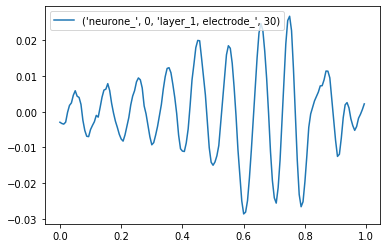

In [366]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [293]:
weights.shape


(2,)

In [308]:
def plot_predictions(batch_trials, batch_num):
    y_true=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    Time = np.linspace(1, 6.25, (time_points - stim))
    

    x_true = format_1[source_Y, batch_trials, :]
    y_pred = np.zeros((batch_num, time_points - stim))  
    
    for i in range(batch_num):
        k = 0
        while k < time_points - stim:
            y_pred[i, k] = model.predict(x_true[i, k : stim + k].reshape((1, stim)))
            k = k + 1
    print(y_pred.shape)
    
    for i in range(y_true.shape[0]):
        plt.figure()
        plt.plot(Time, y_true[i], label = "True")
        plt.plot(Time, y_pred[i], label = "Predicted")
        plt.legend()
    


(19, 840)


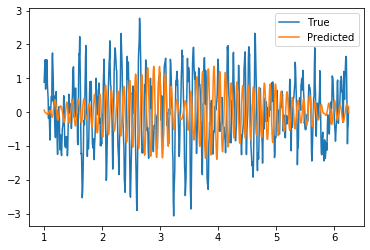

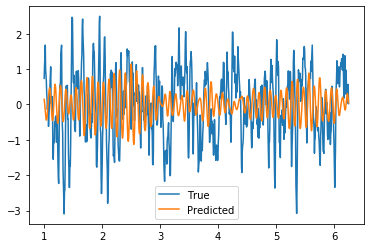

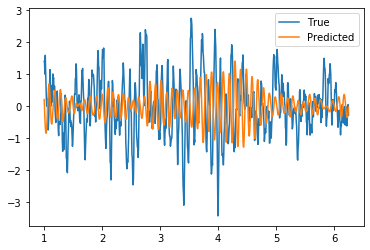

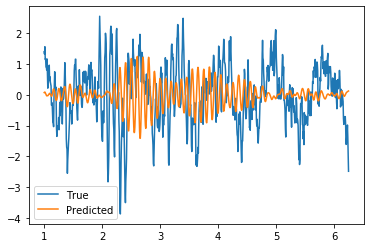

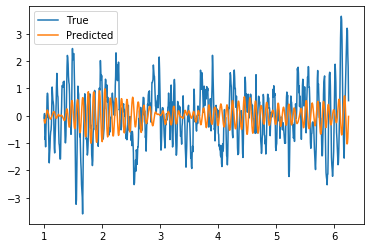

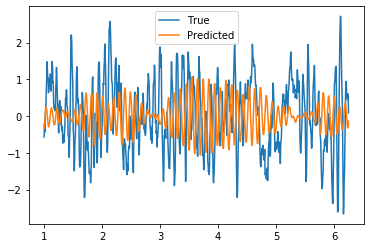

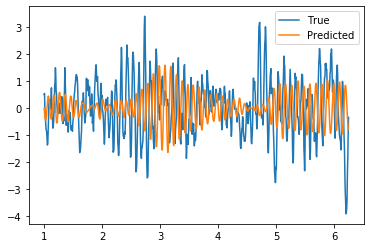

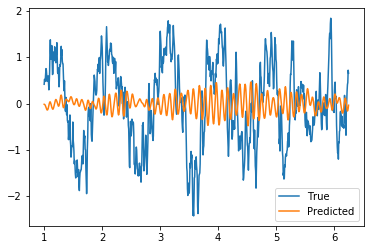

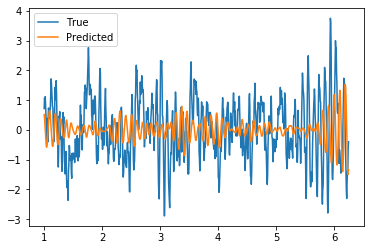

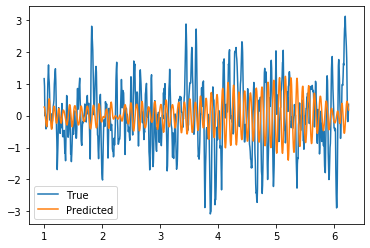

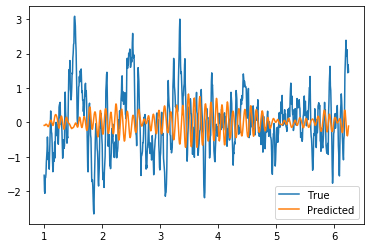

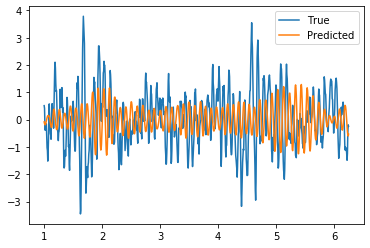

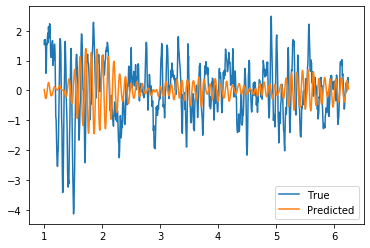

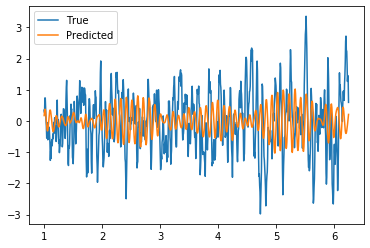

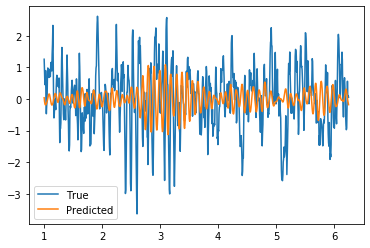

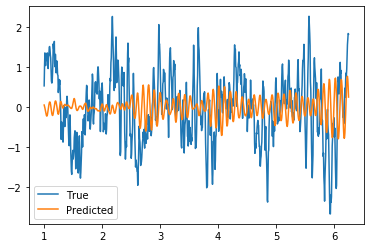

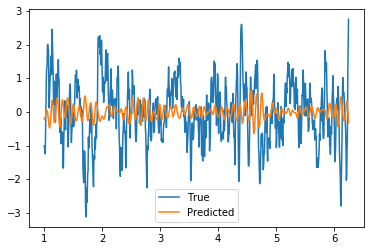

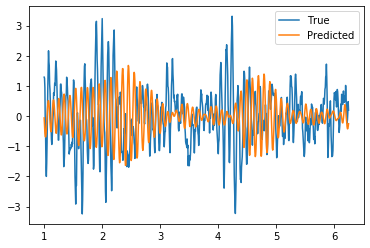

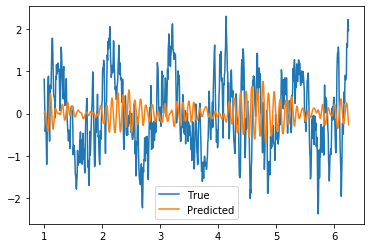

In [309]:
plot_predictions(trials_valid, valid_num)

In [208]:
x_true = format_1[source_Y, trials_valid, :]


x_true.shape

(19, 1000)

In [211]:
x_true[0, 0:160].shape

(160,)